In [3]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP

In [22]:
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.75
COORDS = (55.55074, -4.3278)
IDX = 2

==> Loading data
==> Loaded data in: 0 m : 9 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



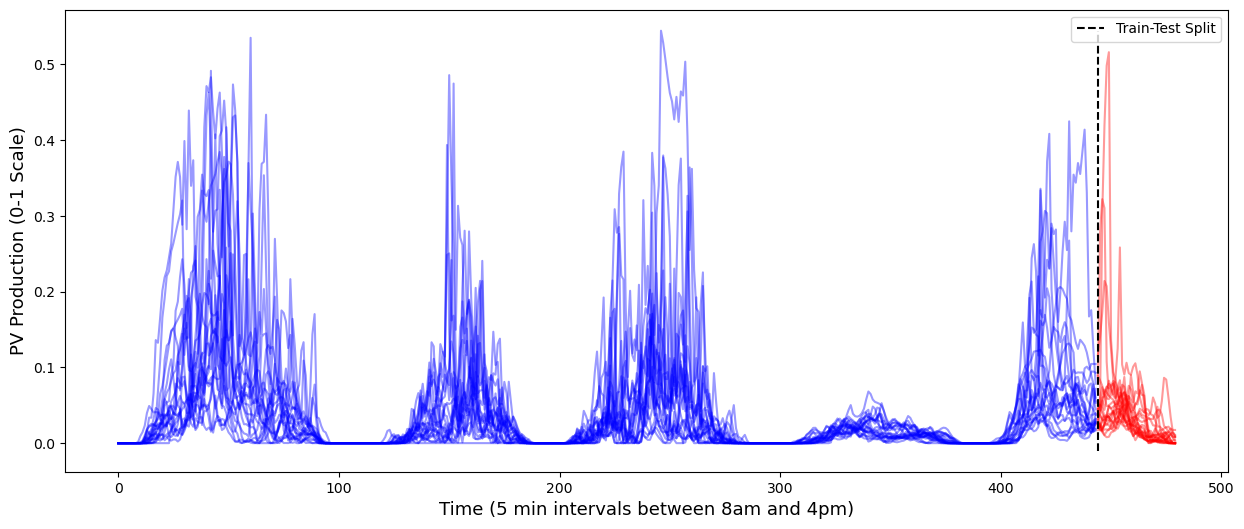

In [23]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=0,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')
time, y = loader.get_time_series()
time_train, y_train, time_test, y_test = dl.train_test_split(time, y, n_hours=3)
plot_train_test_split(time_train, time_test, y_train, y_test)


# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [24]:
from gpytorch.distributions import base_distributions
class BetaLikelihood_MeanParametrization(gpytorch.likelihoods.BetaLikelihood):
	
	def forward(self, function_samples, *args, **kwargs):
		mixture = torch.tanh(function_samples) / 2 + 0.5
	
		scale = self.scale
		self.alpha = mixture * scale
		self.beta = scale - self.alpha

		eps = 1e-10
		
		self.alpha = self.alpha + eps
		self.beta = self.beta + eps
	
		return base_distributions.Beta(concentration1=self.alpha, concentration0=self.beta)

In [25]:
time, y = loader.get_time_series()
y_in = y[:, IDX]

def periodic_mapping(time_steps, day_min, day_max, minute_interval):
    total_minutes = (day_max - day_min) * 60  # Total number of minutes in the specified time range
    normalized_minutes = (time_steps * minute_interval) % total_minutes  # Normalize time steps to minutes

    # Apply periodic mapping using sine function
    mapped_values = torch.sin(2 * torch.pi * normalized_minutes / total_minutes)
    return mapped_values

periodic_time = periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)

# stack time and periodic time to create exogenous variables
x = torch.stack([time, periodic_time], dim=1)

# standardize x
x = (x - x.mean(dim=0)) / x.std(dim=0)

x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

x_inducing = x_train
y_inducing = y_train

In [26]:
l = torch.var(x) / 2
l

tensor(0.4995)

# Kernels

In [27]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the lengthscale in matern, and the period in periodic
# BEST INITS
# matern = MaternKernel(nu=5/2, ard_num_dims=x.shape[1], lengthscale_prior=gpytorch.priors.NormalPrior(1, 0.1))
# kernel = ScaleKernel(matern, lengthscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2))

matern = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
scaled_matern = ScaleKernel(matern, 
                     outputscale_prior=gpytorch.priors.NormalPrior(0.5, 0.5),
                     outputscale_constraint=gpytorch.constraints.Positive()
                    )

periodic = PeriodicKernel(period_length_prior=gpytorch.priors.NormalPrior(0.1, 0.2),
                          period_length_constraint=gpytorch.constraints.Positive()
                        )
scaled_periodic = ScaleKernel(periodic,
                              outputscale_prior=gpytorch.priors.NormalPrior(0.3, 0.05),
                            )

kernel = ScaleKernel(ProductKernel(scaled_matern, periodic))
kernel_add = AdditiveKernel(scaled_matern, kernel)

In [21]:
run = True
jitter = 1e-6

while run:
    config = {
        'type': 'stochastic',
        'name': 'mean_field',
        'num_inducing_points': x_inducing.size(0),
        'mean_init_std': 1,
    }
    inputs_mean = { 'X': x_train, 
                    'y': y_train, 
                    'mean_module': gpytorch.means.ConstantMean(),
                    'covar_module': matern,
                    'likelihood': BetaLikelihood_MeanParametrization(scale_prior=gpytorch.priors.NormalPrior(30, 2),
                                                                    scale_constraint=gpytorch.constraints.Interval(15, 100)),
                    'config': config,
                    'jitter': jitter
                    }

    try:
        model_beta = BetaGP(**inputs_mean)
        model_beta.fit(n_iter=250, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))
        run = False
    except:
        print(f'Not PSD adding jitter {jitter}')
        jitter *= 10

Not PSD adding jitter 1e-06
Not PSD adding jitter 9.999999999999999e-06
Not PSD adding jitter 9.999999999999999e-05
Not PSD adding jitter 0.001
Not PSD adding jitter 0.01
Not PSD adding jitter 0.1
Not PSD adding jitter 1.0
Not PSD adding jitter 10.0
Not PSD adding jitter 100.0
Not PSD adding jitter 1000.0
Not PSD adding jitter 10000.0
Not PSD adding jitter 100000.0
Not PSD adding jitter 1000000.0
Not PSD adding jitter 10000000.0
Not PSD adding jitter 100000000.0
Not PSD adding jitter 1000000000.0
Not PSD adding jitter 10000000000.0
Not PSD adding jitter 100000000000.0
Not PSD adding jitter 1000000000000.0
Not PSD adding jitter 10000000000000.0
Not PSD adding jitter 100000000000000.0
Not PSD adding jitter 1000000000000000.0
Not PSD adding jitter 1e+16
Not PSD adding jitter 1e+17
Not PSD adding jitter 1e+18
Not PSD adding jitter 1e+19
Not PSD adding jitter 1e+20
Not PSD adding jitter 1e+21
Not PSD adding jitter 1e+22
Not PSD adding jitter 1e+23
Not PSD adding jitter 1e+24
Not PSD adding 

KeyboardInterrupt: 

In [ ]:
plt.plot(model_beta.losses);

In [ ]:
plot_gp(model=model_beta, 
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        y_inducing=y_inducing,
        )

model_beta.predict(x_train, device=torch.device('cpu'))
plot_alpha_beta(model_beta)

In [ ]:
model_beta.likelihood.scale.item()